In [122]:
# External dependencies
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import timedelta
from datetime import datetime as dt

# Constants
TRADING_DAYS: int = 10
VOL_TARGET: float = 0.20
TRADING_HOURS_PER_DAY: int = 7
TRADING_30_MIN_PER_DAY: int = TRADING_HOURS_PER_DAY * 2
TRADING_5_MIN_PER_DAY: int = TRADING_HOURS_PER_DAY * 12

In [118]:
dt.timedelta(days=-30) + dt.today().date

AttributeError: type object 'datetime.datetime' has no attribute 'timedelta'

In [ ]:
dt.today().date() + timedelta(days=-30)

datetime.date(2024, 11, 19)

Load Data

In [127]:
daily = yf.download(tickers="SPY", interval="1d")["Close"].pct_change()
hourly = yf.download(tickers="SPY", start=dt.today().date() + timedelta(days=-365), interval="1h")["Close"].pct_change()
min_30 = yf.download(tickers="SPY", start=dt.today().date() + timedelta(days=-30), interval="30m")["Close"].pct_change()
min_5 = yf.download(tickers="SPY", start=dt.today().date() + timedelta(days=-30), interval="5m")["Close"].pct_change()

returns = pd.concat(
    [
        daily,
        hourly,
        min_30,
        min_5
    ],
    axis=1
)
returns.columns = ["1d", "1h", "30m", "5m"]
returns

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,1d,1h,30m,5m
1993-01-29 00:00:00+00:00,NaN,NaN,NaN,NaN
1993-02-01 00:00:00+00:00,0.007112,NaN,NaN,NaN
1993-02-02 00:00:00+00:00,0.002119,NaN,NaN,NaN
1993-02-03 00:00:00+00:00,0.010571,NaN,NaN,NaN
1993-02-04 00:00:00+00:00,0.004184,NaN,NaN,NaN
...,...,...,...,...
2024-12-19 15:25:00+00:00,NaN,NaN,NaN,-0.000764
2024-12-19 15:30:00+00:00,NaN,0.002055,NaN,-0.001019
2024-12-19 15:35:00+00:00,NaN,NaN,NaN,0.000765
2024-12-19 15:40:00+00:00,NaN,NaN,NaN,0.001776


Build Exponentially Weighted Risk Model

In [128]:
risk_model = pd.concat(
    [
        (returns["1d"].dropna().ewm(halflife=TRADING_DAYS / 2).std().dropna() * np.sqrt(252)).tail(20),
        (returns["1h"].dropna().ewm(halflife=TRADING_DAYS * TRADING_HOURS_PER_DAY / 2).std().dropna() * np.sqrt(TRADING_HOURS_PER_DAY * 252)).tail(20 * TRADING_HOURS_PER_DAY),
        (returns["30m"].dropna().ewm(halflife=TRADING_DAYS * TRADING_30_MIN_PER_DAY / 2).std().dropna() * np.sqrt(TRADING_30_MIN_PER_DAY * 252)).tail(20 * TRADING_30_MIN_PER_DAY),
        (returns["5m"].dropna().ewm(halflife=TRADING_DAYS * TRADING_5_MIN_PER_DAY / 2).std().dropna() * np.sqrt(TRADING_5_MIN_PER_DAY * 252)).tail(20 * TRADING_5_MIN_PER_DAY)
    ],
    axis=1
).ffill()
risk_model.columns = ["1d", "1h", "30m", "5m"]
risk_model["mean"] = risk_model.mean(axis=1)
risk_model["mean"].iloc[-1].round(4)

0.1436

Plot Ex Ante Risk

<Axes: title={'center': 'Ex Ante Volatility'}>

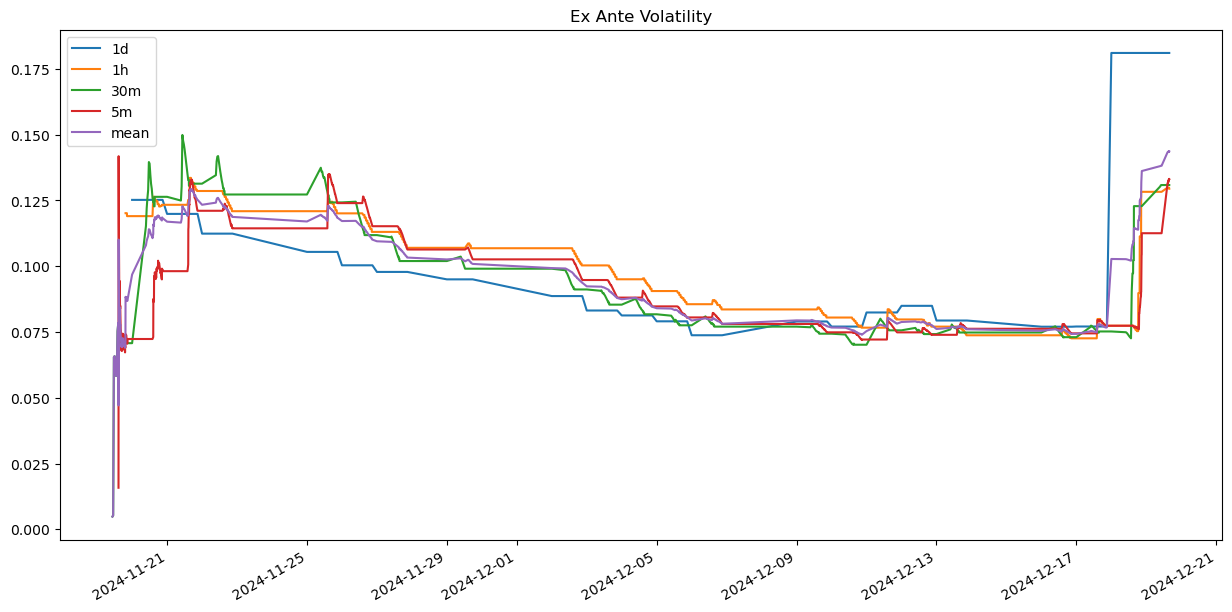

In [129]:
risk_model.plot(title="Ex Ante Volatility", figsize=(15, 7.5))

In [130]:
leverage_target = VOL_TARGET / risk_model["mean"].iloc[-1].round(4)
leverage_target

1.392757660167131

In [137]:
2 * risk_model["mean"].iloc[-1].round(4)

0.2872